In [29]:
import os, sys, re, datetime
import numpy as np
import astropy.units as u
from astropy.table import Table
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))

In [30]:
in_table = Table.read('out_table_R_CI10CO21_sim_XCICO_1pX_20210923a.csv', format='csv')

In [31]:
out_fig_name = 'Plot_R_CI10CO21_sim_XCICO_1pX'

In [32]:
# User defined global parameters

list_N_CO = 10**np.arange(17.0, 20.0, 0.25)
list_X_CICO = np.arange(0.05, 1.0+0.05, 0.05)
list_n_H2 = [1e3, 1e4, 1e5, 1e6]
list_T_kin = [25., 50., 100.]
dV = 30. # * u.km/u.s

Output to "Plot_R_CI10CO21_sim_XCICO_1pX_LTE_varying_N_CO_T_kin.pdf"


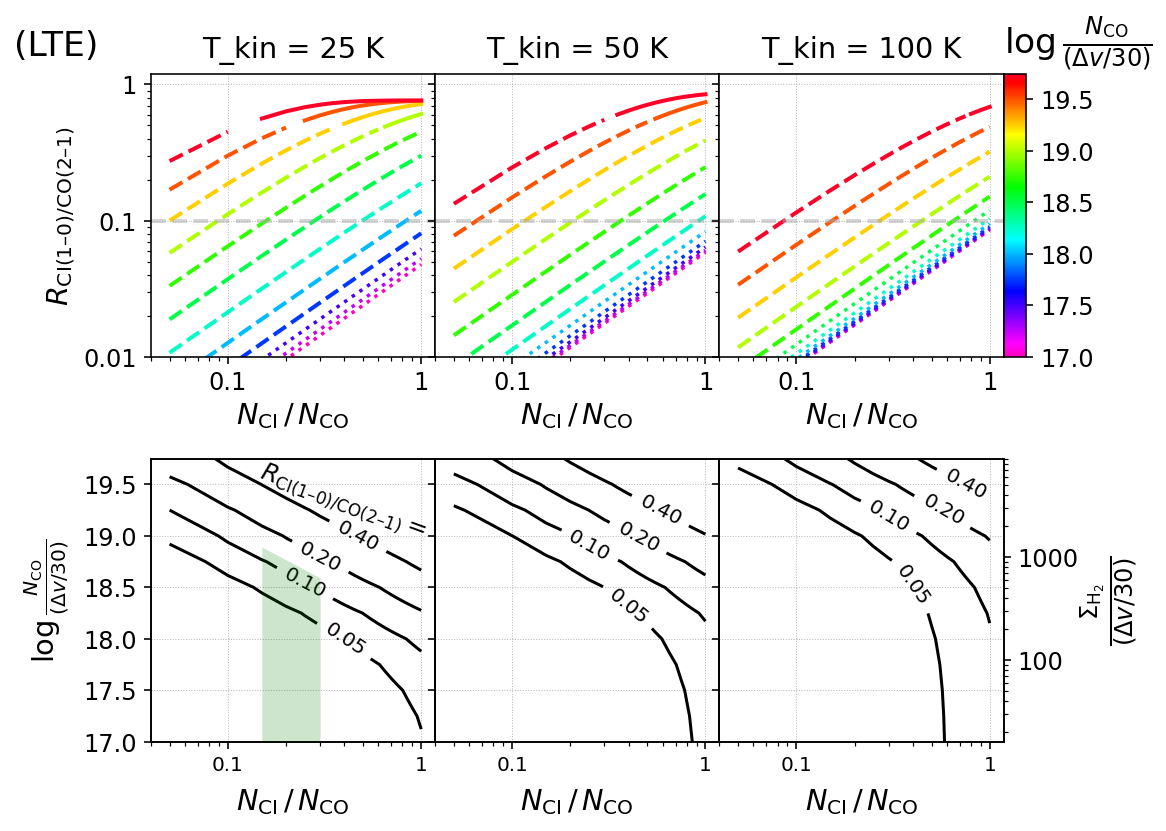

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

#out_figure_file = out_fig_name + '_LTE_varying_N_CO_T_kin.pdf'

def make_a_figure(
        in_table, 
        out_figure_file, 
        n_H2 = 1e4, 
        LTE = False, 
    ):
    minima = np.nan
    maxima = np.nan
    fig = plt.figure(figsize=(8, 5.8))
    gs = gridspec.GridSpec(ncols=len(list_T_kin)+1, nrows=2, figure=fig, width_ratios=[1]*len(list_T_kin)+[0.08], wspace=0, hspace=0.36)
    upper_axes = []
    for i in range(len(list_T_kin)):
        upper_axes.append(fig.add_subplot(gs[0, i]))
    lower_axes = []
    for i in range(len(list_T_kin)):
        lower_axes.append(fig.add_subplot(gs[1, i]))
    fig.subplots_adjust(left=0.12, right=0.88, bottom=0.10, top=0.90)
    lower_right_axes = []

    #norm = matplotlib.colors.LogNorm(vmin=np.min(list_N_CO), vmax=np.max(list_N_CO), clip=True)
    norm = matplotlib.colors.Normalize(vmin=np.min(np.log10(list_N_CO)), vmax=np.max(np.log10(list_N_CO)), clip=True)
    cmap = cm.gist_rainbow_r # cm.RdYlBu_r # cm.gist_rainbow_r # cm.RdYlBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
    colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    for i_T_kin, T_kin in enumerate(list_T_kin):

        x_array_for_contour = []
        y_array_for_contour = []
        data_array_for_contour = []

        icol = i_T_kin

        for i_N_CO, N_CO in enumerate(list_N_CO):

            #N_CO_str = '{:.0e}'.format(N_CO).replace('e+','e')
            N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
            dV_str = '{:.0f}'.format(dV)
            T_kin_str = '{:.0f}'.format(T_kin)
            #n_H2 = 1e4
            n_H2_str = '{:.1e}'.format(N_CO).replace('e+','e')

            mask = np.logical_and.reduce((
                    np.isclose(np.log10(in_table['N_CO']), np.log10(N_CO)), 
                    np.isclose(np.log10(in_table['n_H2']), np.log10(n_H2)), 
                    np.isclose(in_table['T_kin'], T_kin), 
                ))

            this_table = in_table[mask]

            ax = upper_axes[icol]

            ax.set_title(f'T_kin = {T_kin_str} K', fontsize='x-large', pad=8)

            ax.set_xlabel(r'$N_{\mathrm{CI}} \, / \, N_{\mathrm{CO}}$', fontsize='x-large', labelpad=3)

            if icol == 0:
                ax.set_ylabel(r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', fontsize='x-large', labelpad=3)

            if icol != 0:
                ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel

            ax.tick_params(labelsize='large')

            x = this_table['X_CICO']
            if LTE: 
                y = this_table['R_CI10CO21_LTE']
                mask_CO_opt_thin = this_table['tau_0_CO21_LTE']<1.
                mask_CI_opt_thin = this_table['tau_0_CI10_LTE']<1.
            else:
                y = this_table['R_CI10CO21_NonLTE']
                mask_CO_opt_thin = this_table['tau_0_CO21_NonLTE']<1.
                mask_CI_opt_thin = this_table['tau_0_CI10_NonLTE']<1.

            # plot R_CI10CO21 versus X_CICO curves in the upper panel
            mask = np.logical_and(mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), lw=1.75, ls='dotted', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), lw=2.0, ls='dashed', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, ~mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), lw=2.0, ls='solid', alpha=1.0)

            # compute global extrema
            miny = np.min(y)
            maxy = np.max(y)
            if np.isnan(minima) or minima > miny:
                minima = miny
            if np.isnan(maxima) or maxima < maxy:
                maxima = maxy

            # prepare data array for contour
            x_array_for_contour.append(x) # X_CICO
            y_array_for_contour.append(np.log10(N_CO))
            data_array_for_contour.append(y) # R_CI10CO21

        # plot contour in the lower panel
        x = x_array_for_contour[0]
        y = y_array_for_contour
        ax = lower_axes[icol]
        cs = ax.contour(x, y, data_array_for_contour, levels=[0.05, 0.1, 0.2, 0.4], colors='k') # show R_CICO = 0.05, 0.1 and 0.2 contours
        ax.set_xlabel(r'$N_{\mathrm{CI}} \, / \, N_{\mathrm{CO}}$', fontsize='x-large', labelpad=6)
        ax.set_xscale('log')
        ax.set_xlim([0.04, 1.18])
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        axRight = ax.twinx()
        axRight.set_yscale('log')
        axRight.set_ylim(10**np.array(ax.get_ylim()) / 1e-4 * 1.60141791e-20) # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / const.M_sun = 1.60141791e-20, [CO/H2] = 1e-4
        if icol == 0:
            ax.set_ylabel(r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v/%.0f)}$'%(dV), fontsize='x-large', labelpad=6) # show y axis title in the last column panel
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
            ax.tick_params(axis='y', labelsize='large')
            axRight.yaxis.set_tick_params(which='both', size=0) # hide right y ticks
            axRight.yaxis.set_major_formatter(ticker.NullFormatter()) # hide right y ticks
            axRight.yaxis.set_minor_formatter(ticker.NullFormatter()) # hide right y ticks
        elif icol == len(list_T_kin)-1:
            #axRight.set_ylabel(r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v/%.0f)}$'%(dV), fontsize='x-large', labelpad=6) # show right y axis title in the last column panel
            axRight.set_ylabel(r'$\frac{\Sigma_{\mathrm{H_2}}}{(\Delta v/%.0f)}$'%(dV), fontsize='xx-large', labelpad=0) # show right y axis title in the last column panel
            #axRight.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
            #axRight.yaxis.set_major_locator(ticker.LogLocator())
            axRight.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g')) # show right y axis tick labels
            axRight.tick_params(axis='y', labelsize='large')
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks at left
        else:
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-last-column panel
            axRight.yaxis.set_tick_params(which='both', size=0) # hide right y ticks in the non-last-column panel
            axRight.yaxis.set_major_formatter(ticker.NullFormatter()) # hide right y ticks in the non-last-column panel
            axRight.yaxis.set_minor_formatter(ticker.NullFormatter()) # hide right y ticks in the non-last-column panel
        ax.clabel(cs, cs.levels, inline=True)
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        lower_right_axes.append(axRight)

    # adjust upper panel limits and axes styles
    for ax in upper_axes:
        ax.set_ylim([minima - 0.08*(maxima-minima), maxima + 0.08*(maxima-minima)])
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        ax.set_ylim([0.01, 1.2])
        ax.set_xlim([0.04, 1.18])
        ax.plot(ax.get_xlim(), [0.1, 0.1], ls='dashed', lw=2, alpha=0.5, color='#aaaaaa')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks
        #ax.set_xticks([0.1, 0.2])
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        #ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    upper_axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

    # plot LTE text
    if LTE:
        upper_axes[0].text(-0.48, 1.04, '(LTE)', ha='left', va='bottom', fontsize='xx-large', transform=upper_axes[0].transAxes)
    else:
        upper_axes[0].text(-0.48, 1.04, '(Non-LTE)', ha='left', va='bottom', fontsize='xx-large', transform=upper_axes[0].transAxes)

    # plot text in contour
    lower_axes[0].text(0.14, 19.0, r'$R_{\mathrm{CI(1–0)/CO(2–1)}} = $', rotation=-20, fontsize='large')

    # plot shading in contour
    #lower_right_axes[0].set_ylim(lower_right_axes[0].get_ylim())
    lower_right_axes[0].fill_between([0.15, 0.3], 
                                     [lower_right_axes[0].get_ylim()[0]]*2, 
                                     np.array([1000, 500])/0.8, 
                                     color='green', alpha=0.2, lw=0)

    # plot upper panel color bar
    colorbar_title = r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v/%.0f)}$'%(dV)
    colorbar_ticks = list_N_CO # ['{:.0e}'.format(N_CO).replace('e+','e') for N_CO in list_N_CO]
    ax_colorbar = fig.add_subplot(gs[0, -1])
    ax_colorbar.set_title(colorbar_title, fontsize='xx-large', pad=10, loc='left')
    ax_colorbar.tick_params(labelsize='large')
    cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
    #if colorbar_ticks is not None:
    #    cbar.set_ticks(colorbar_ticks)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    #cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    #cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    #cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.5,), numdecs=0))

    #fig.tight_layout()

    fig.savefig(out_figure_file, dpi=300)
    print(f'Output to "{out_figure_file}"')
    
    return fig


fig = make_a_figure(
        in_table, 
        out_figure_file = out_fig_name + '_LTE_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e4, 
        LTE = True, 
    )


Output to "Plot_R_CI10CO21_sim_XCICO_1pX_NonLTE_nH2_1e3_varying_N_CO_T_kin.pdf"


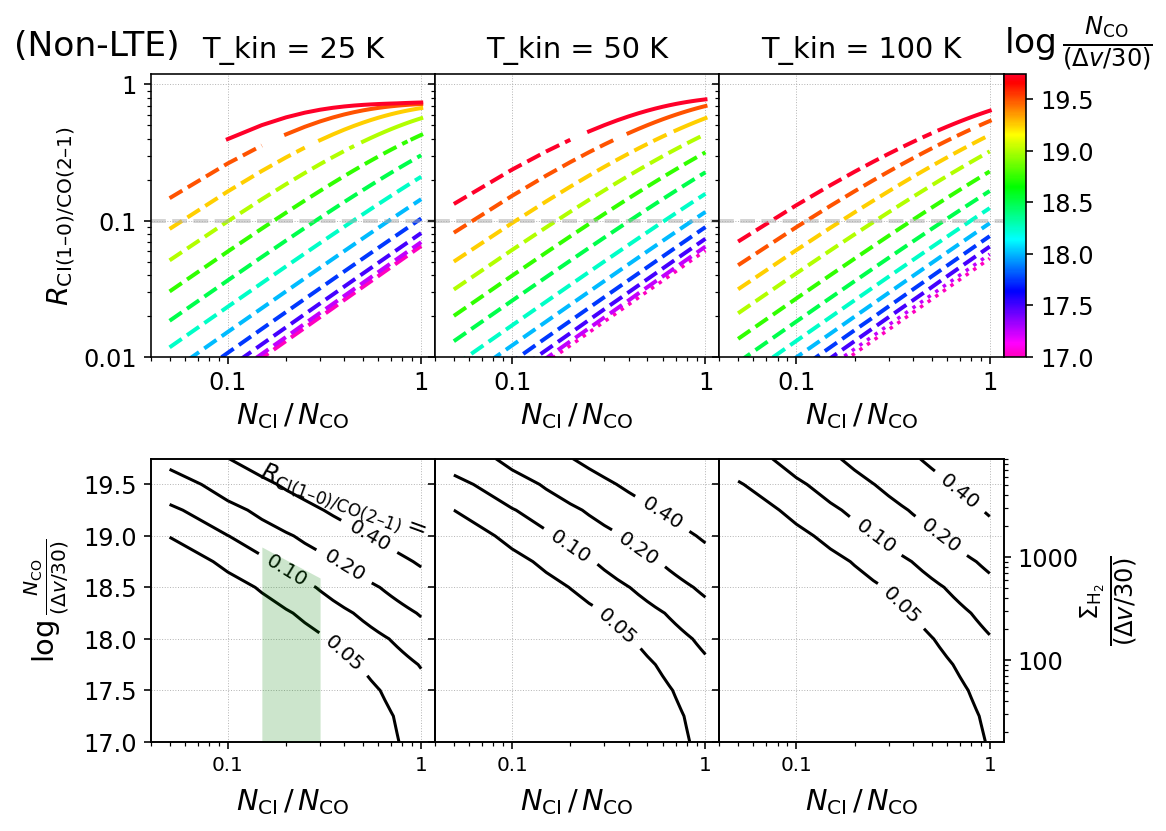

In [34]:

fig = make_a_figure(
        in_table, 
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e3_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e3, 
        LTE = False, 
    )


Output to "Plot_R_CI10CO21_sim_XCICO_1pX_NonLTE_nH2_1e4_varying_N_CO_T_kin.pdf"


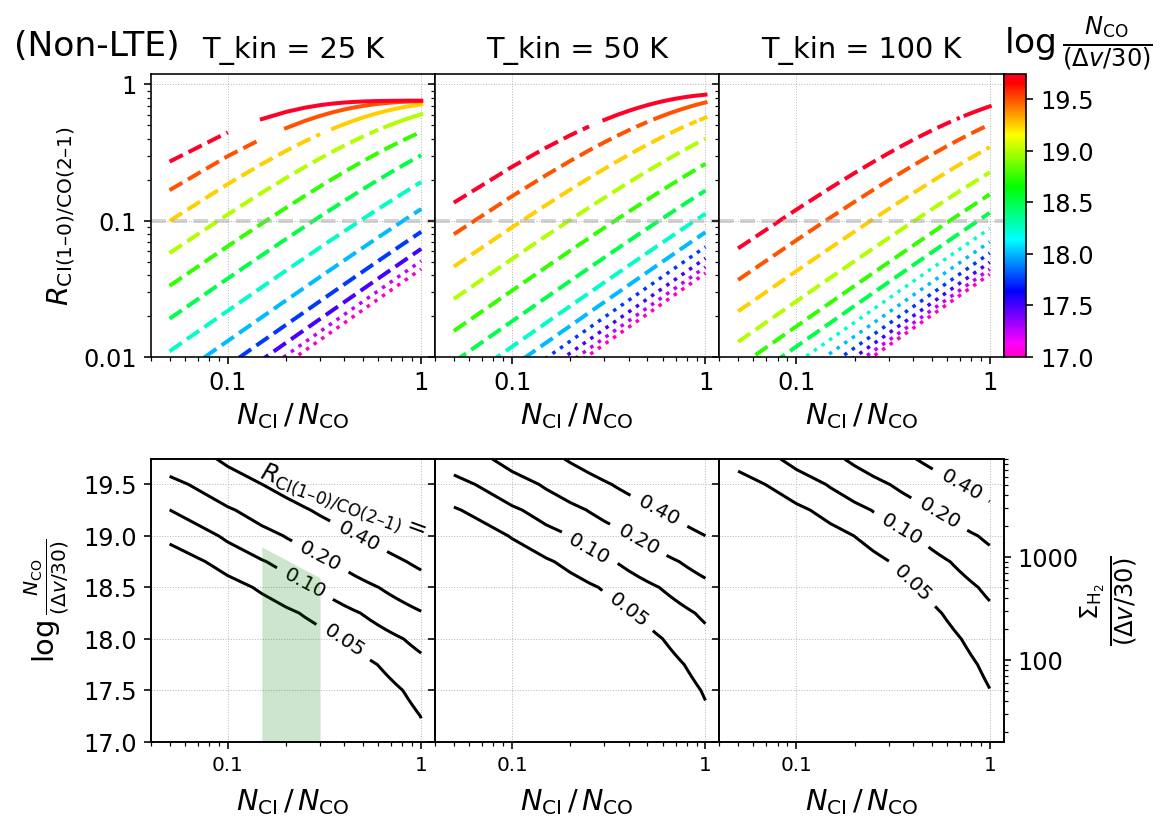

In [35]:

fig = make_a_figure(
        in_table, 
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e4_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e4, 
        LTE = False, 
    )


Output to "Plot_R_CI10CO21_sim_XCICO_1pX_NonLTE_nH2_1e5_varying_N_CO_T_kin.pdf"


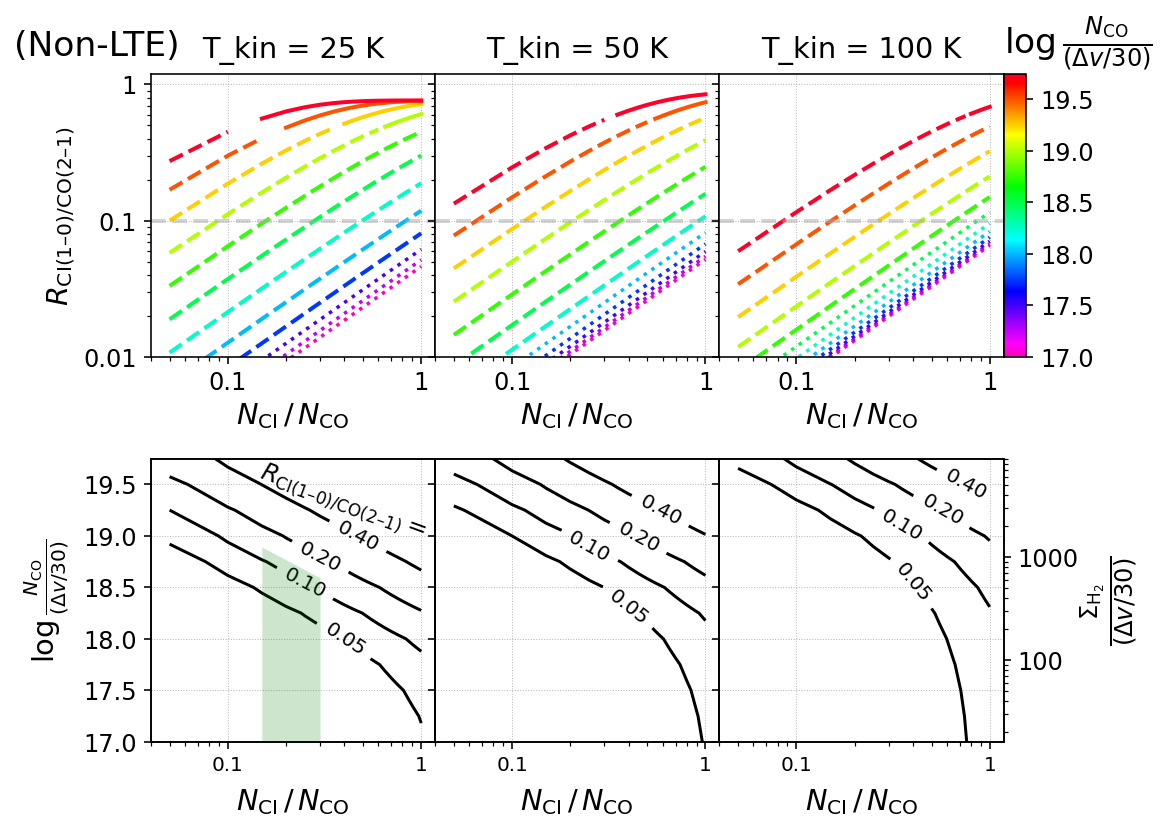

In [36]:

fig = make_a_figure(
        in_table, 
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e5_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e5, 
        LTE = False, 
    )


Output to "Plot_R_CI10CO21_sim_XCICO_1pX_NonLTE_nH2_1e6_varying_N_CO_T_kin.pdf"


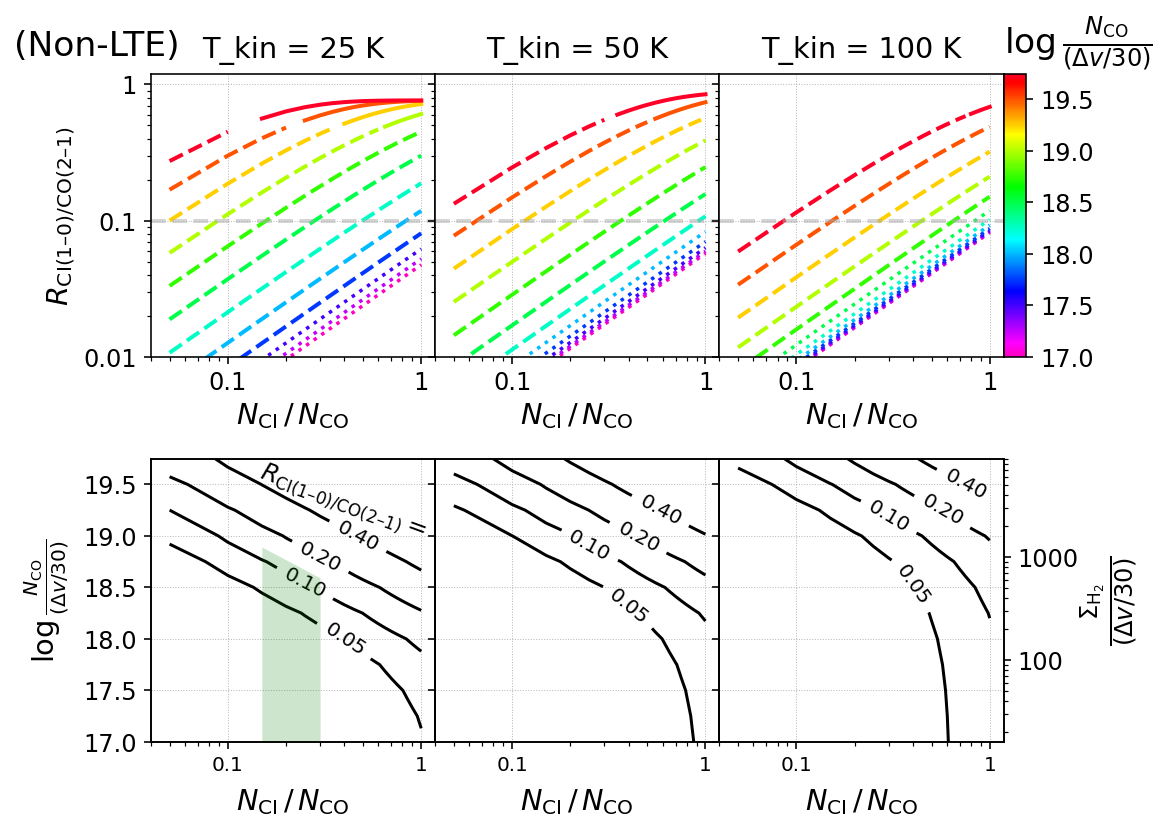

In [37]:

fig = make_a_figure(
        in_table, 
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e6_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e6, 
        LTE = False, 
    )
